# Support Intelligence & Risk Monitoring — Data Analyst Notebook (T2)

**Goal:** Exploratory Data Analysis (EDA) + Data Quality checks on a customer support tickets dataset to prepare a robust pipeline for:
- **Support automation** (triage, priority prediction, response suggestion, routing)
- **Risk monitoring** (anomaly detection: spikes in queues/tags/priority, abnormal behaviors)

---

## What this notebook covers
1. Dataset overview (schema, size, languages)  
2. Data quality (missingness, duplicates, outliers)  
3. Distributions (priority, queue, ticket type)  
4. Text characteristics (length, extremes)  
5. Tags exploration (coverage, top tags, long tail)  
6. Consistency checks (Type×Priority, Queue×Priority, Tag×Queue)  
7. Key insights + next steps (T3: cleaning & feature engineering)


In [67]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib as mpl


## 0) Configuration: path + theme (portfolio-ready)

✅ Choose your dataset file and use a consistent figure style.


In [68]:
PATH = "archive(1)/aa_dataset-tickets-multi-lang-5-2-50-version.csv"  # change if needed

THEME = {
    "bg": "#ffffff",
    "panel": "#f8fafc",
    "text": "#0f172a",
    "muted": "#475569",
    "grid": "#cbd5e1",
    "border": "#e2e8f0",
    "blue": "#2563eb",
    "green": "#22c55e",
    "orange": "#f59e0b",
    "red": "#ef4444",
    "purple": "#a855f7",
    "teal": "#14b8a6",
}

plt.rcParams.update({
    "figure.facecolor": THEME["bg"],
    "axes.facecolor": THEME["panel"],
    "axes.edgecolor": THEME["border"],
    "axes.labelcolor": THEME["muted"],
    "xtick.color": THEME["muted"],
    "ytick.color": THEME["muted"],
    "text.color": THEME["text"],
    "axes.titleweight": "bold",
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "font.size": 11,
    "axes.grid": True,
    "grid.color": THEME["grid"],
    "grid.alpha": 0.18,
    "axes.spines.top": False,
    "axes.spines.right": False
})

def nice_title(ax, title, subtitle=None):
    ax.set_title(title, loc="center", pad=12)
    if subtitle:
        ax.text(0, 1.02, subtitle, transform=ax.transAxes,
                ha="left", va="bottom", fontsize=11, alpha=0.8)

def annotate_hbar(ax, values, fmt="{:,}"):
    m = max(values) if len(values) else 1
    for y, v in enumerate(values):
        ax.text(v + m*0.01, y, fmt.format(int(v)), va="center", fontsize=11)


## 1) Load data + quick overview

In [69]:
PATH = "C:/Users/hp/Desktop/mon portfolio/Support intellegence and risk monitoring system/archive(1)/aa_dataset-tickets-multi-lang-5-2-50-version.csv"
df = pd.read_csv(PATH)
print("Full dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head(3)


Full dataset shape: (28587, 16)
Columns: ['subject', 'body', 'answer', 'type', 'queue', 'priority', 'language', 'version', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']


,subject,body,answer,type,queue,priority,language,version,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Wesentlicher Sicherheitsvorfall,"Sehr geehrtes Support-Team,\n\nich möchte eine...",Vielen Dank für die Meldung des kritischen Sic...,Incident,Technical Support,high,de,51,Security,Outage,Disruption,Data Breach,NaN,NaN,NaN,NaN
1,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...","Thank you for reaching out, <name>. We are awa...",Incident,Technical Support,high,en,51,Account,Disruption,Outage,IT,Tech Support,NaN,NaN,NaN
2,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Thank you for your inquiry. Our products suppo...,Request,Returns and Exchanges,medium,en,51,Product,Feature,Tech Support,NaN,NaN,NaN,NaN,NaN


## 2) Filter English (EN) — baseline scope

For a clean first version (V1), we focus on English tickets to build the initial pipeline and models.


In [70]:
df_en = df[df["language"] == "en"].copy()
print("EN shape:", df_en.shape)
df_en.head(3)


EN shape: (16338, 16)


,subject,body,answer,type,queue,priority,language,version,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
1,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...","Thank you for reaching out, <name>. We are awa...",Incident,Technical Support,high,en,51,Account,Disruption,Outage,IT,Tech Support,NaN,NaN,NaN
2,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Thank you for your inquiry. Our products suppo...,Request,Returns and Exchanges,medium,en,51,Product,Feature,Tech Support,NaN,NaN,NaN,NaN,NaN
3,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",We appreciate you reaching out with your billi...,Request,Billing and Payments,low,en,51,Billing,Payment,Account,Documentation,Feedback,NaN,NaN,NaN


## 3) Schema & Missingness (Data Dictionary)

In [71]:
data_dict = pd.DataFrame({
    "col": df_en.columns,
    "dtype": [str(df_en[c].dtype) for c in df_en.columns],
    "missing_%": (df_en.isna().mean() * 100).round(2).values
}).sort_values("missing_%", ascending=False)

data_dict


,col,dtype,missing_%
15,tag_8,object,98.28
14,tag_7,object,93.06
13,tag_6,object,79.37
12,tag_5,object,48.49
0,subject,object,15.96
11,tag_4,object,10.47
10,tag_3,object,0.42
9,tag_2,object,0.04
2,answer,object,0.02
6,language,object,0.00


### Key missing fields to watch
- `subject` can be missing: we will later build a robust `message = subject + body` with fallback on `body`.
- `tag_1..tag_8` contain NaNs because tags are optional per ticket (normal).


In [72]:
# subject missing (NaN OR empty string)
subject_missing = df_en["subject"].isna() | (df_en["subject"].astype(str).str.strip() == "")
print("Subject missing:", subject_missing.sum(), "/", len(df_en), f"({subject_missing.mean()*100:.2f}%)")


Subject missing: 2607 / 16338 (15.96%)


## 4) Tags columns + tags coverage

In [73]:
tag_cols = [c for c in df_en.columns if re.fullmatch(r"tag_\d+", str(c))]
tag_cols


['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']

In [74]:
# number of non-null tag columns per ticket
n_tags = df_en[tag_cols].notna().sum(axis=1)
print("n_tags distribution:")
display(n_tags.value_counts().sort_index())
print("No-tag tickets:", (n_tags==0).sum(), "/", len(df_en))


n_tags distribution:


1       6
2      63
3    1642
4    6211
5    5046
6    2236
7     853
8     281
Name: count, dtype: int64

No-tag tickets: 0 / 16338


## 5) Duplicates check (important for NLP)

We check duplicates on:
- `body` only  
- `subject + body`


In [75]:
body_key = df_en["body"].fillna("").astype(str).str.strip()
subj_key = df_en["subject"].fillna("").astype(str).str.strip()
sub_body_key = subj_key + "||" + body_key

dup_body_pct = body_key.duplicated().mean() * 100
dup_sub_body_pct = sub_body_key.duplicated().mean() * 100

print(f"Duplicate rate (body): {dup_body_pct:.2f}%")
print(f"Duplicate rate (subject+body): {dup_sub_body_pct:.2f}%")


Duplicate rate (body): 0.01%
Duplicate rate (subject+body): 0.00%


## 6) Core distributions (Priority / Queue / Type)

In [76]:
priority_counts = df_en["priority"].value_counts()
queue_counts = df_en["queue"].value_counts()
type_counts = df_en["type"].value_counts()

display(priority_counts)
display(type_counts)
display(queue_counts.head(15))


priority
medium    6618
high      6346
low       3374
Name: count, dtype: int64

type
Incident    6571
Request     4665
Problem     3397
Change      1705
Name: count, dtype: int64

queue
Technical Support                  4737
Product Support                    3073
Customer Service                   2410
IT Support                         1942
Billing and Payments               1595
Returns and Exchanges               820
Service Outages and Maintenance     664
Sales and Pre-Sales                 513
Human Resources                     348
General Inquiry                     236
Name: count, dtype: int64

### Figure A — Priority distribution (color-coded)

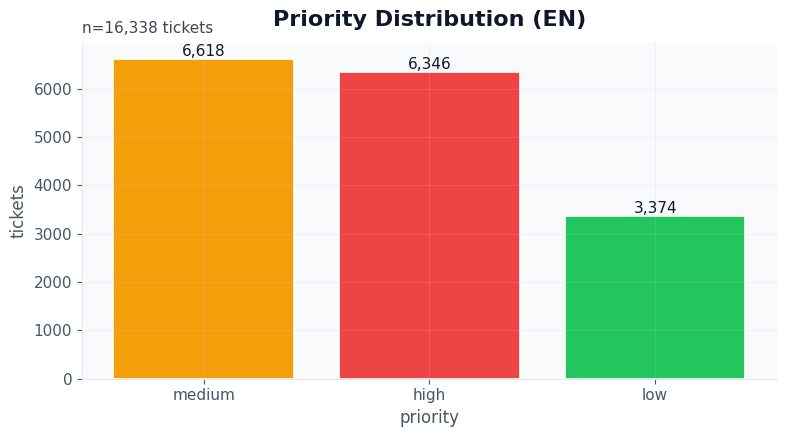

In [77]:
colors = {"low": THEME["green"], "medium": THEME["orange"], "high": THEME["red"]}
bar_colors = [colors.get(k, THEME["blue"]) for k in priority_counts.index]

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.bar(priority_counts.index, priority_counts.values, color=bar_colors, edgecolor="white", linewidth=1.2)
nice_title(ax, "Priority Distribution (EN)", subtitle=f"n={len(df_en):,} tickets")
ax.set_xlabel("priority")
ax.set_ylabel("tickets")

for i, v in enumerate(priority_counts.values):
    ax.text(i, v, f"{v:,}", ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()


### Figure B — Top 15 Queues (dashboard style)

C:\Users\hp\AppData\Local\Temp\ipykernel_17852\4058200814.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("viridis")


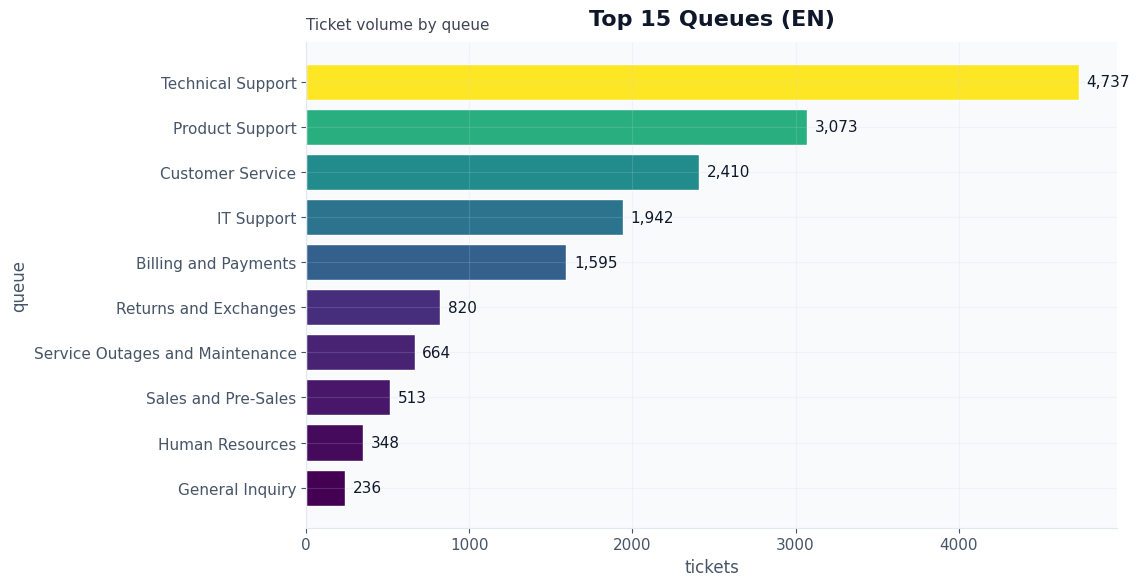

In [78]:
topN = 15
q = df_en["queue"].value_counts().head(topN).sort_values()  # sorted for barh

cmap = mpl.cm.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=q.min(), vmax=q.max())
colors_q = [cmap(norm(v)) for v in q.values]

fig, ax = plt.subplots(figsize=(11.5, 6))
ax.barh(q.index, q.values, color=colors_q, edgecolor="white", linewidth=1.0)
nice_title(ax, f"Top {topN} Queues (EN)", subtitle="Ticket volume by queue")
ax.set_xlabel("tickets")
ax.set_ylabel("queue")
annotate_hbar(ax, q.values)

plt.tight_layout()
plt.show()


### Figure C — Ticket Type distribution

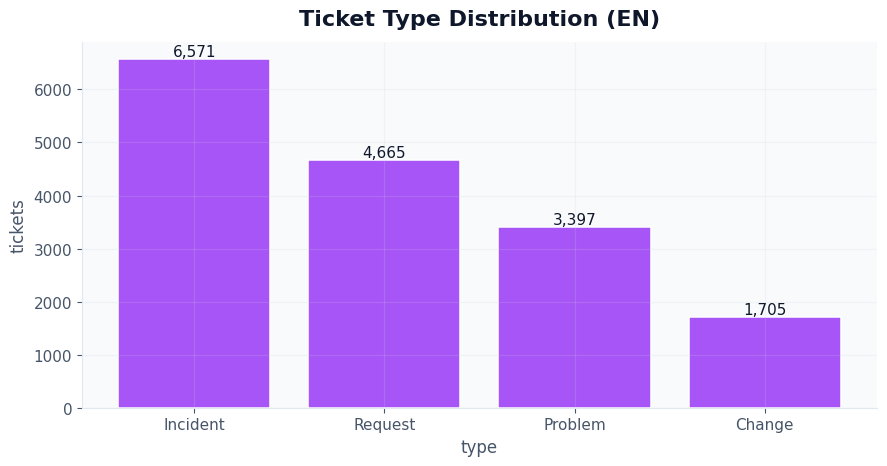

In [79]:
fig, ax = plt.subplots(figsize=(9, 4.8))
ax.bar(type_counts.index, type_counts.values, color=THEME["purple"], edgecolor="white", linewidth=1.1)
nice_title(ax, "Ticket Type Distribution (EN)")
ax.set_xlabel("type")
ax.set_ylabel("tickets")

for i, v in enumerate(type_counts.values):
    ax.text(i, v, f"{v:,}", ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()


## 7) Subject missing rate by queue (same style as queues)

C:\Users\hp\AppData\Local\Temp\ipykernel_17852\3821063834.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("viridis")


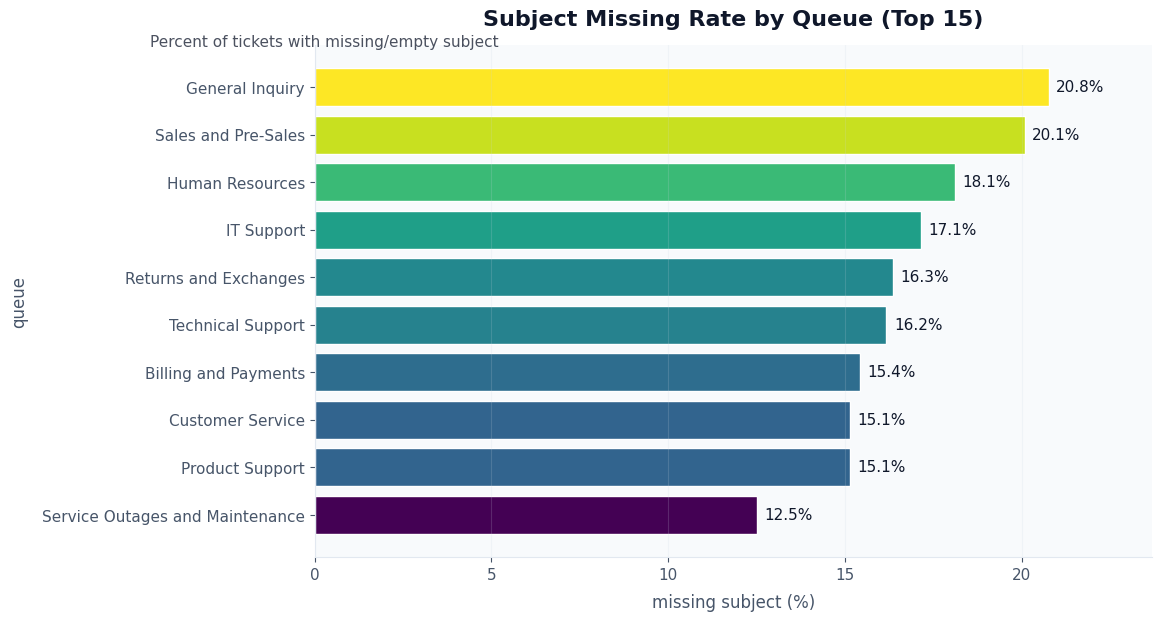

In [80]:
def plot_missing_subject_like_queue_style(df_en, topN=15):
    subject_missing = df_en["subject"].isna() | (df_en["subject"].astype(str).str.strip() == "")
    rate = (df_en.assign(subject_missing=subject_missing)
                .groupby("queue")["subject_missing"]
                .mean()
                .sort_values(ascending=False)
                .head(topN))

    labels = rate.index.tolist()[::-1]
    values = (rate.values * 100)[::-1]

    cmap = mpl.cm.get_cmap("viridis")
    norm = mpl.colors.Normalize(vmin=min(values), vmax=max(values))
    colors = [cmap(norm(v)) for v in values]

    fig, ax = plt.subplots(figsize=(11.5, 6.1), constrained_layout=True)
    ax.barh(labels, values, color=colors, edgecolor="white", linewidth=1.0)

    ax.grid(True, axis="x", alpha=0.18)
    ax.grid(False, axis="y")
    ax.set_xlabel("missing subject (%)", labelpad=8)
    ax.set_ylabel("queue", labelpad=10)

    ax.set_title("Subject Missing Rate by Queue (Top 15)", fontsize=16, fontweight="bold", pad=14)
    fig.text(0.125, 0.94, "Percent of tickets with missing/empty subject",
             ha="left", va="center", fontsize=11, alpha=0.75)

    ax.set_xlim(0, max(values) * 1.14)

    for y, v in enumerate(values):
        ax.text(v + max(values)*0.01, y, f"{v:.1f}%", va="center", fontsize=11)

    plt.show()

plot_missing_subject_like_queue_style(df_en, topN=15)


## 8) Text length analysis (Body + Subject)

Understanding text length helps set modeling constraints (max_length, truncation, vectorization, etc.).


In [81]:
body_len = df_en["body"].fillna("").astype(str).str.len()
subj_len = df_en["subject"].fillna("").astype(str).str.len()

print("Body length stats:", body_len.describe(percentiles=[.5, .9, .95]).to_dict())
print("Subject length stats:", subj_len.describe(percentiles=[.5, .9, .95]).to_dict())


Body length stats: {'count': 16338.0, 'mean': 367.8873791161709, 'std': 179.88572487739123, 'min': 6.0, '50%': 377.0, '90%': 580.0, '95%': 604.0, 'max': 1147.0}
Subject length stats: {'count': 16338.0, 'mean': 36.65130370914433, 'std': 21.392467402801163, 'min': 0.0, '50%': 39.0, '90%': 61.0, '95%': 69.0, 'max': 234.0}


### Figure D — Body length histogram + percentiles

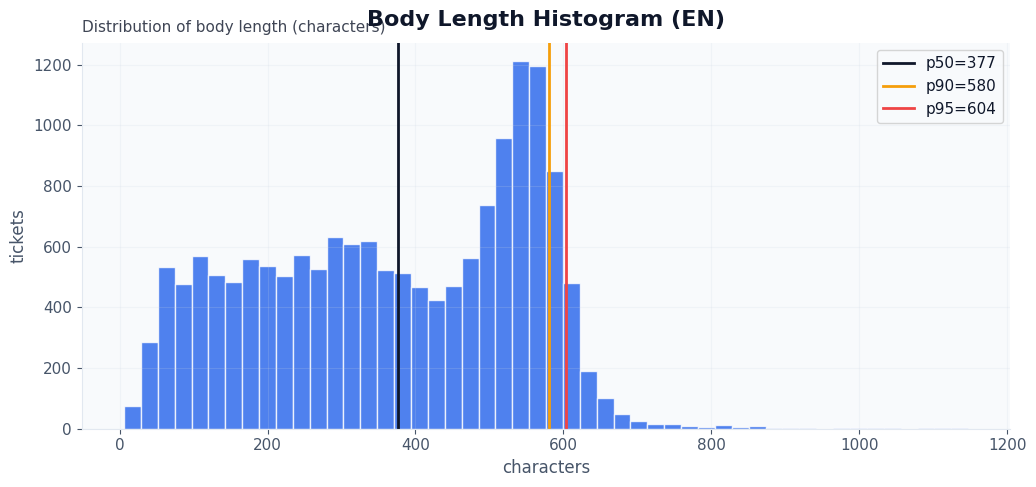

In [82]:
p50 = int(body_len.median())
p90 = int(body_len.quantile(0.90))
p95 = int(body_len.quantile(0.95))

fig, ax = plt.subplots(figsize=(10.5, 5))
ax.hist(body_len, bins=50, color=THEME["blue"], alpha=0.80, edgecolor="white")
nice_title(ax, "Body Length Histogram (EN)", subtitle="Distribution of body length (characters)")
ax.set_xlabel("characters")
ax.set_ylabel("tickets")

ax.axvline(p50, color=THEME["text"], linewidth=2, label=f"p50={p50}")
ax.axvline(p90, color=THEME["orange"], linewidth=2, label=f"p90={p90}")
ax.axvline(p95, color=THEME["red"], linewidth=2, label=f"p95={p95}")
ax.legend()

plt.tight_layout()
plt.show()


## 9) Consistency checks (Type×Priority and Queue×Priority)

These checks verify whether the label behavior looks plausible.


### Figure E — Type × Priority heatmap (row-normalized %)

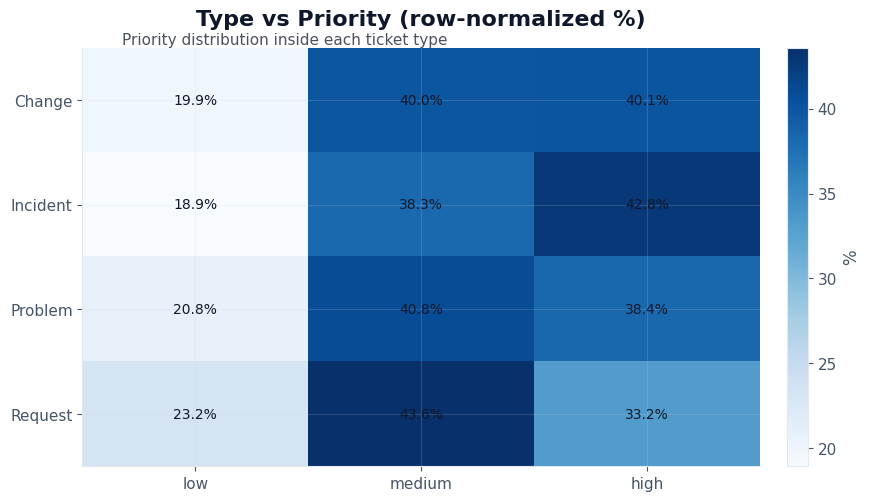

In [83]:
ct = pd.crosstab(df_en["type"], df_en["priority"], normalize="index") * 100
ct = ct.reindex(columns=["low","medium","high"], fill_value=0)

fig, ax = plt.subplots(figsize=(8.6, 4.9), constrained_layout=True)
im = ax.imshow(ct.values, aspect="auto", cmap="Blues")

# Title (no overlap)
ax.set_title("Type vs Priority (row-normalized %)", fontsize=16, fontweight="bold", pad=16)

# Subtitle placed at figure level (safe)
fig.text(0.135, 0.93, "Priority distribution inside each ticket type",
         ha="left", va="center", fontsize=11, alpha=0.75)

ax.set_xticks(range(ct.shape[1]))
ax.set_xticklabels(ct.columns)
ax.set_yticks(range(ct.shape[0]))
ax.set_yticklabels(ct.index)

for i in range(ct.shape[0]):
    for j in range(ct.shape[1]):
        ax.text(j, i, f"{ct.values[i, j]:.1f}%", ha="center", va="center",
                fontsize=10, color=THEME["text"])

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("%")

plt.show()


### Figure F — Priority mix within top queues (stacked bars)

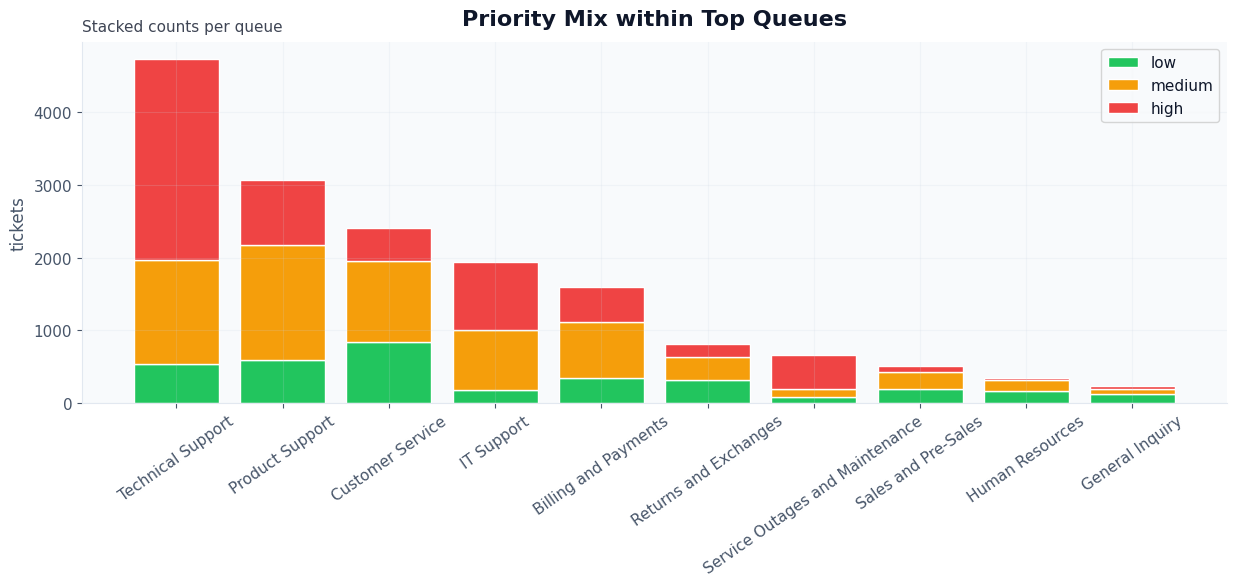

In [84]:
topN = 10
topq = df_en["queue"].value_counts().head(topN).index
sub = df_en[df_en["queue"].isin(topq)].copy()

mix = pd.crosstab(sub["queue"], sub["priority"])
mix = mix.reindex(columns=["low","medium","high"], fill_value=0)
mix = mix.loc[topq]

fig, ax = plt.subplots(figsize=(12.5, 6))
low = mix["low"].values
med = mix["medium"].values
high = mix["high"].values

ax.bar(mix.index, low, color=THEME["green"], label="low", edgecolor="white", linewidth=1)
ax.bar(mix.index, med, bottom=low, color=THEME["orange"], label="medium", edgecolor="white", linewidth=1)
ax.bar(mix.index, high, bottom=low+med, color=THEME["red"], label="high", edgecolor="white", linewidth=1)

nice_title(ax, "Priority Mix within Top Queues", subtitle="Stacked counts per queue")
ax.set_ylabel("tickets")
ax.tick_params(axis="x", rotation=35)
ax.legend()

plt.tight_layout()
plt.show()


## 10) Tags analysis
We inspect:
- Top tags
- Long tail behavior
- Tag × Queue relationship (routing signal)


In [85]:
all_tags = df_en[tag_cols].stack().dropna().astype(str).str.strip()
all_tags = all_tags[~all_tags.str.lower().isin(["nan","none","null",""])]

print("Unique tags:", all_tags.nunique())
top_tags = all_tags.value_counts().head(20)
top_tags


Unique tags: 886


Tech Support     9597
IT               9320
Performance      7536
Feedback         4814
Bug              3956
Security         3811
Feature          3741
Disruption       3428
Documentation    3425
Outage           2574
Network          2159
Sales            1615
Recovery         1555
Product          1358
Billing           922
Hardware          874
Payment           785
Marketing         732
Support           715
Crash             676
Name: count, dtype: int64

### Figure G — Top 20 tags (barh)

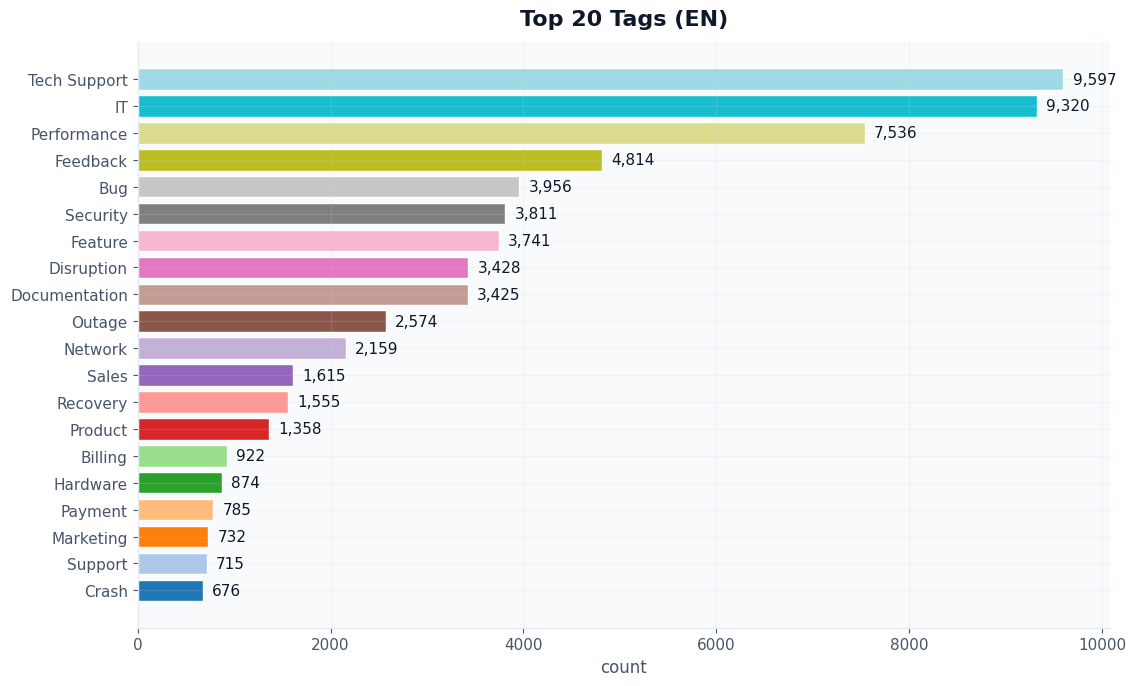

In [86]:
topK = 20
top_tags = all_tags.value_counts().head(topK).sort_values()

palette = plt.cm.tab20(np.linspace(0, 1, len(top_tags)))

fig, ax = plt.subplots(figsize=(11.5, 7))
ax.barh(top_tags.index, top_tags.values, color=palette, edgecolor="white", linewidth=1.0)
nice_title(ax, f"Top {topK} Tags (EN)")
ax.set_xlabel("count")
annotate_hbar(ax, top_tags.values)

plt.tight_layout()
plt.show()


### Figure H — Tag long-tail coverage (cumulative curve)

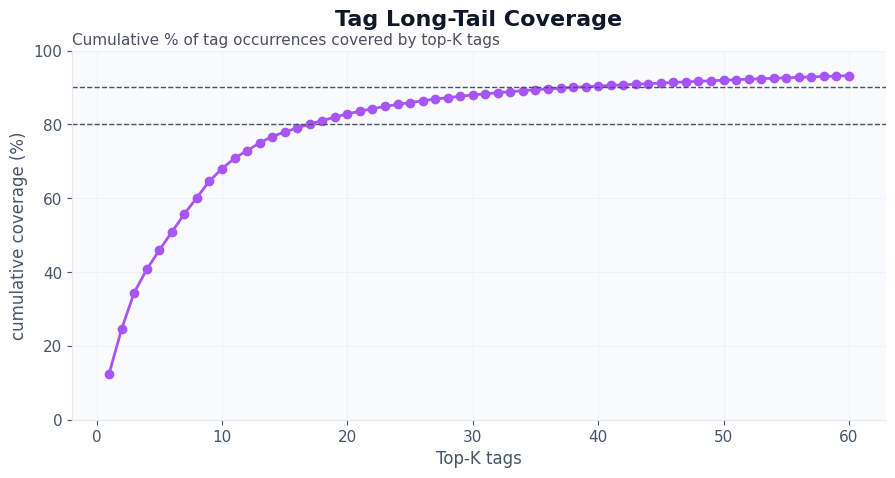

In [87]:
freq = all_tags.value_counts()
cum = (freq.cumsum() / freq.sum()) * 100

K = min(60, len(cum))
x = np.arange(1, K+1)
y = cum.iloc[:K].values

fig, ax = plt.subplots(figsize=(10.5, 5.2))
fig.subplots_adjust(top=0.82)  # espace pour titre + sous-titre

ax.plot(x, y, marker="o", linewidth=2, color=THEME["purple"])

# Title + subtitle (no overlap)
ax.set_title("Tag Long-Tail Coverage", fontsize=16, fontweight="bold", pad=18)
fig.text(0.125, 0.84, "Cumulative % of tag occurrences covered by top-K tags",
         ha="left", va="center", fontsize=11, alpha=0.75)

ax.set_xlabel("Top-K tags")
ax.set_ylabel("cumulative coverage (%)")
ax.set_ylim(0, 100)

ax.axhline(80, color=THEME["muted"], linestyle="--", linewidth=1)
ax.axhline(90, color=THEME["muted"], linestyle="--", linewidth=1)

plt.show()


### Figure I — Tag × Queue heatmap (Top tags vs Top queues)

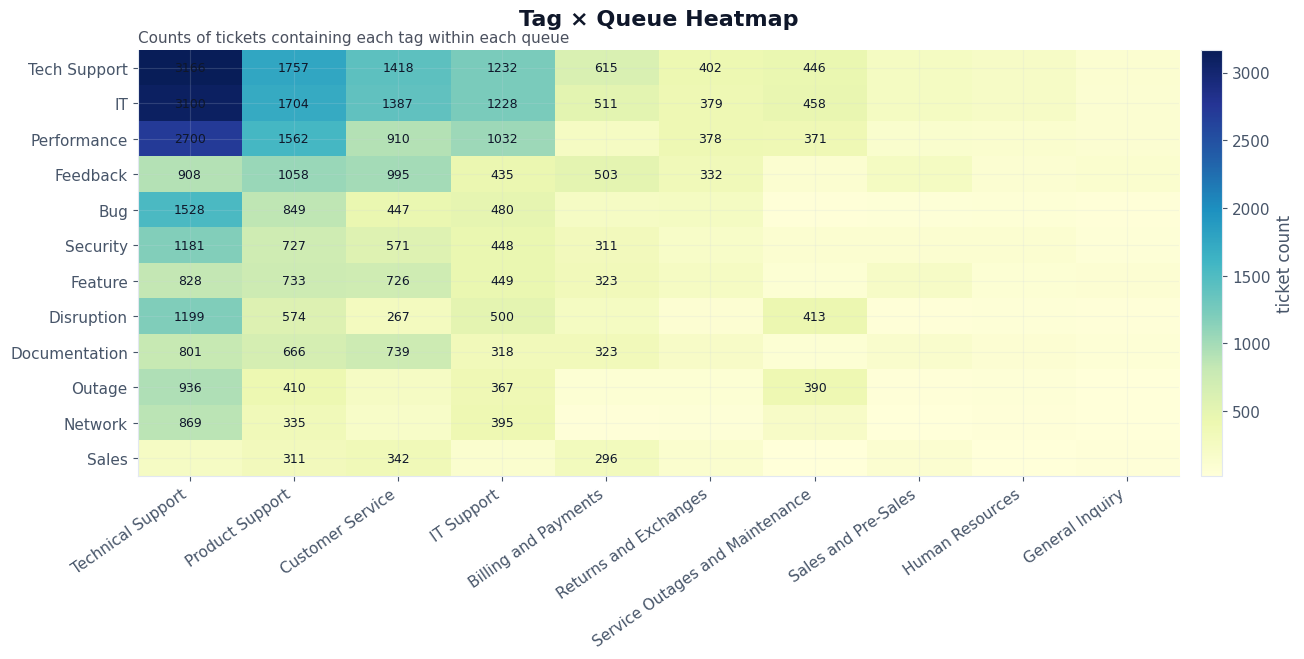

In [88]:
top_tags_list = all_tags.value_counts().head(12).index.tolist()
top_queues_list = df_en["queue"].value_counts().head(10).index.tolist()

tmp = df_en[["queue"] + tag_cols].copy()
tmp = tmp[tmp["queue"].isin(top_queues_list)]

long_tags = (
    tmp.melt(id_vars=["queue"], value_vars=tag_cols, value_name="tag")
       .drop(columns=["variable"])
       .dropna()
)
long_tags["tag"] = long_tags["tag"].astype(str).str.strip()
long_tags = long_tags[~long_tags["tag"].str.lower().isin(["nan","none","null",""])]
long_tags = long_tags[long_tags["tag"].isin(top_tags_list)]

heat = pd.crosstab(long_tags["tag"], long_tags["queue"])
heat = heat.reindex(index=top_tags_list, columns=top_queues_list, fill_value=0)

fig, ax = plt.subplots(figsize=(14, 6))
fig.subplots_adjust(top=0.82)  # espace titre + sous-titre

im = ax.imshow(heat.values, aspect="auto", cmap="YlGnBu")

# Title + subtitle (no overlap)
ax.set_title("Tag × Queue Heatmap", fontsize=16, fontweight="bold", pad=18)
fig.text(0.125, 0.84, "Counts of tickets containing each tag within each queue",
         ha="left", va="center", fontsize=11, alpha=0.75)

ax.set_xticks(range(len(heat.columns)))
ax.set_xticklabels(heat.columns, rotation=35, ha="right")
ax.set_yticks(range(len(heat.index)))
ax.set_yticklabels(heat.index)

maxv = heat.values.max() if heat.values.size else 0
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        v = heat.values[i, j]
        if v > 0 and v >= maxv * 0.08:
            ax.text(j, i, f"{int(v)}", ha="center", va="center",
                    fontsize=9, color=THEME["text"])

cbar = plt.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
cbar.set_label("ticket count")

plt.show()



## 11) Key insights (fill after running)

Use this template after execution:

- Dataset size (EN): **...**
- Subject missing rate: **...%** → we will build `message = subject + body` with fallback on body (T3)
- Priority distribution: **...**
- Top queues: **...**
- Tags coverage: % tickets without tags + average `n_tags`
- Long tail: top-K tags cover **...%** of occurrences
- Consistency: Type×Priority and Queue×Priority patterns seem plausible for operations monitoring.

---

## 12) Next steps (Pipeline plan)

**Why:** Turn EDA insights into a reproducible dataset that can be reused by models, dashboards, and anomaly monitoring.  
**Output:** `tickets_clean_en.parquet` as a single “analytics-ready” source.

- Build a clean ML-ready dataset:
  - Text: `subject_clean`, `body_clean`, `message` (subject+body), `subject_filled`
  - Tags: merge `tag_1..tag_8` → `tags` (list) + `tags_str` (string)
  - Quality/features: `body_len`, `has_subject`, `n_tags`
- Create a first business taxonomy: **Billing / Bug / Account / Other**
- Export: `data/processed/tickets_clean_en.parquet`
